In [1]:
import netCDF4
import xarray as xr
import pandas as pd

# Data extraction

## multilevel nO2 and O3

In [2]:
ds_multilevel = xr.open_dataset(r'..\raw\330366cb145f51715a38afdf09361614\data_allhours_mlev.nc', engine='netcdf4')
print(ds_multilevel)

<xarray.Dataset>
Dimensions:      (valid_time: 60, model_level: 1, latitude: 11, longitude: 17)
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 2020-01-01T21:00:00 ... 2024-12-...
  * model_level  (model_level) float64 60.0
  * latitude     (latitude) float64 43.5 42.75 42.0 41.25 ... 37.5 36.75 36.0
  * longitude    (longitude) float64 -9.3 -8.55 -7.8 -7.05 ... 0.45 1.2 1.95 2.7
Data variables:
    no2          (valid_time, model_level, latitude, longitude) float32 ...
    go3          (valid_time, model_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-17T08:58 GRIB to CDM+CF via cfgrib-0.9.1...


## single? level NO2 O3 and relative humidity

In [3]:
ds_plev= xr.open_dataset(r'..\raw\330366cb145f51715a38afdf09361614\data_allhours_plev.nc', engine='netcdf4')
print(ds_plev)

<xarray.Dataset>
Dimensions:         (valid_time: 60, pressure_level: 1, latitude: 11,
                     longitude: 17)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 2020-01-01 ... 2024-12-01
  * pressure_level  (pressure_level) float64 1e+03
  * latitude        (latitude) float64 43.5 42.75 42.0 41.25 ... 37.5 36.75 36.0
  * longitude       (longitude) float64 -9.3 -8.55 -7.8 -7.05 ... 1.2 1.95 2.7
Data variables:
    no2             (valid_time, pressure_level, latitude, longitude) float32 ...
    go3             (valid_time, pressure_level, latitude, longitude) float32 ...
    r               (valid_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-17T08:5

# 2m temp, PM2.5, PM10

In [4]:
ds_srf = xr.open_dataset(r'..\raw\330366cb145f51715a38afdf09361614\data_allhours_sfc.nc', engine='netcdf4')
print(ds_srf)

<xarray.Dataset>
Dimensions:     (valid_time: 60, latitude: 11, longitude: 17)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01 2020-02-01 ... 2024-12-01
  * latitude    (latitude) float64 43.5 42.75 42.0 41.25 ... 37.5 36.75 36.0
  * longitude   (longitude) float64 -9.3 -8.55 -7.8 -7.05 ... 0.45 1.2 1.95 2.7
Data variables:
    t2m         (valid_time, latitude, longitude) float32 ...
    pm2p5       (valid_time, latitude, longitude) float32 ...
    pm10        (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-17T08:58 GRIB to CDM+CF via cfgrib-0.9.1...


## Convert factors to Dataframe

In [5]:
df_multilevel = ds_multilevel[['no2', 'go3']].to_dataframe().reset_index()

In [6]:
df_plev = ds_plev[['no2','go3','r']].to_dataframe().reset_index()

In [7]:
df_srf = ds_srf[['t2m','pm2p5','pm10']].to_dataframe().reset_index()

## EDA

In [8]:
df_multilevel.head()

,valid_time,model_level,latitude,longitude,no2,go3
0,2020-01-01 21:00:00,60.0,43.5,-9.30,7.872124e-09,5.285335e-08
1,2020-01-01 21:00:00,60.0,43.5,-8.55,7.777942e-09,4.907596e-08
2,2020-01-01 21:00:00,60.0,43.5,-7.80,6.610907e-09,4.924097e-08
3,2020-01-01 21:00:00,60.0,43.5,-7.05,1.058472e-08,4.638215e-08
4,2020-01-01 21:00:00,60.0,43.5,-6.30,1.442159e-08,4.349993e-08



## Converting the units

NO2 and O3 are in kg/kg. We need to convert them to ug/m3

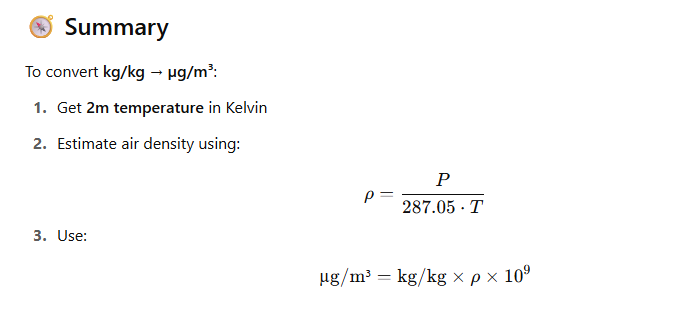

## Estimating the air density

In [9]:
def compute_air_density(t2m, pressure_pa=100000):
    """
    Calculate air density using the ideal gas law.
    
    Parameters:
    - t2m: temperature at 2 meters in Kelvin
    - pressure_pa: air pressure at 2 meters in Pascals (default is 100000 Pa = 1000 hPa)

    Returns:
    - Air density in kg/m³
    """
    R_d = 287.05  # specific gas constant for dry air [J/(kg·K)]
    return pressure_pa / (R_d * t2m)


## Converting to um/m3

In [10]:
def mixing_ratio_to_concentration(mixing_ratio, t2m, pressure_pa=100000):
    """
    Convert mass mixing ratio (kg/kg) to concentration (µg/m³).
    """
    return mixing_ratio * compute_air_density(t2m, pressure_pa) * 1e9  # µg/m³


In [11]:
# Calculate and add new column
df_multilevel['no2_ugm3'] = mixing_ratio_to_concentration(df_multilevel['no2'], df_srf['t2m'])
df_multilevel['go3_ugm3'] = mixing_ratio_to_concentration(df_multilevel['go3'], df_srf['t2m'])


In [12]:
df_multilevel.describe()

,valid_time,model_level,latitude,longitude,no2,go3,no2_ugm3,go3_ugm3
count,11220,11220.0,11220.000000,11220.000000,1.122000e+04,1.122000e+04,11220.000000,11220.000000
mean,2022-06-17 12:12:00,60.0,39.750000,-3.300000,6.076123e-09,5.845351e-08,7.334299,70.114358
min,2020-01-01 21:00:00,60.0,36.000000,-9.300000,4.587254e-10,2.115154e-08,0.546902,25.966614
25%,2021-03-25 03:00:00,60.0,37.500000,-6.300000,3.826285e-09,4.732997e-08,4.578437,57.667946
50%,2022-06-16 21:00:00,60.0,39.750000,-3.300000,5.285909e-09,5.826094e-08,6.408036,69.895851
75%,2023-09-09 09:00:00,60.0,42.000000,-0.300000,7.414716e-09,6.760256e-08,9.021466,80.291475
max,2024-12-01 21:00:00,60.0,43.500000,2.700000,6.225140e-08,1.300598e-07,73.402328,151.100383
std,NaN,0.0,2.371814,3.674398,3.798563e-09,1.526949e-08,4.572326,17.354302


## Adding new column with converted units

In [13]:
df_plev['no2_ugm3'] = mixing_ratio_to_concentration(df_plev['no2'], df_srf['t2m'])
df_plev['go3_ugm3'] = mixing_ratio_to_concentration(df_plev['go3'], df_srf['t2m'])
df_plev

,valid_time,pressure_level,latitude,longitude,no2,go3,r,no2_ugm3,go3_ugm3
0,2020-01-01,1000.0,43.5,-9.30,3.806506e-09,6.140378e-08,80.973572,4.647283,74.966584
1,2020-01-01,1000.0,43.5,-8.55,5.232743e-09,5.519681e-08,80.529724,6.416771,67.686355
2,2020-01-01,1000.0,43.5,-7.80,5.549844e-09,5.328664e-08,79.068298,6.823361,65.514272
3,2020-01-01,1000.0,43.5,-7.05,9.696244e-09,5.053582e-08,76.884705,11.966081,62.365975
4,2020-01-01,1000.0,43.5,-6.30,1.288172e-08,4.812533e-08,75.178162,15.937606,59.541937
...,...,...,...,...,...,...,...,...,...
11215,2024-12-01,1000.0,36.0,-0.30,8.181460e-09,6.858531e-08,58.127670,9.865254,82.700578
11216,2024-12-01,1000.0,36.0,0.45,9.724883e-09,5.976331e-08,59.286362,11.813453,72.598407
11217,2024-12-01,1000.0,36.0,1.20,1.400674e-08,4.814637e-08,62.521225,17.178827,59.050021
11218,2024-12-01,1000.0,36.0,1.95,2.121175e-08,4.252417e-08,63.125717,26.177126,52.478482


## WHO thresholds are given in ppb, so we're converting um/m3 to ppb

In [14]:
def ugm3_to_ppb(conc_ugm3, molar_mass):
    # Convert µg/m³ to ppb at 25°C (298.15 K) and 1 atm
    # R (ideal gas constant) and molar volume approx 24.45 L/mol at these conditions
    return conc_ugm3 * 24.45 / molar_mass

df_multilevel['no2_ppb'] = ugm3_to_ppb(df_multilevel['no2_ugm3'], 46.0055)
df_multilevel['o3_ppb'] = ugm3_to_ppb(df_multilevel['go3_ugm3'], 47.9982)

## Converting units PM2.5 and PM10

In [15]:
df_srf['pm2p5_ugm3'] = df_srf['pm2p5'] * 1e9
df_srf['pm10_ugm3'] = df_srf['pm10'] * 1e9

# Merge and Export

In [16]:
df_merged = pd.merge(df_srf, df_multilevel.drop(columns='valid_time'), on = ['latitude', 'longitude'], how = 'inner')

In [17]:
df_merged = pd.merge(df_merged, df_plev[['latitude','longitude', 'r']], on = ['latitude', 'longitude'], how = 'inner')
df_merged.head()

,valid_time,latitude,longitude,t2m,pm2p5,pm10,pm2p5_ugm3,pm10_ugm3,model_level,no2,go3,no2_ugm3,go3_ugm3,no2_ppb,o3_ppb,r
0,2020-01-01,43.5,2.7,280.456543,1.534261e-08,2.179717e-08,15.34261,21.797174,60.0,8.641658e-09,3.982010e-08,10.734306,49.462863,5.704835,25.196091,81.134216
1,2020-01-01,43.5,2.7,280.456543,1.534261e-08,2.179717e-08,15.34261,21.797174,60.0,8.641658e-09,3.982010e-08,10.734306,49.462863,5.704835,25.196091,78.065903
2,2020-01-01,43.5,2.7,280.456543,1.534261e-08,2.179717e-08,15.34261,21.797174,60.0,8.641658e-09,3.982010e-08,10.734306,49.462863,5.704835,25.196091,73.320084
3,2020-01-01,43.5,2.7,280.456543,1.534261e-08,2.179717e-08,15.34261,21.797174,60.0,8.641658e-09,3.982010e-08,10.734306,49.462863,5.704835,25.196091,74.006836
4,2020-01-01,43.5,2.7,280.456543,1.534261e-08,2.179717e-08,15.34261,21.797174,60.0,8.641658e-09,3.982010e-08,10.734306,49.462863,5.704835,25.196091,70.939789


In [18]:
# df_merged.go3_ugm3 = df_merged.go3_ugm3.astype('float32')
df_merged[['latitude', 'longitude', 't2m','pm2p5_ugm3', 'pm10_ugm3', 'no2_ppb', 'o3_ppb', 'r']] = df_merged[['latitude', 'longitude', 't2m','pm2p5_ugm3', 'pm10_ugm3', 'no2_ppb', 'o3_ppb', 'r']].astype('float32')

In [ ]:
# df_merged.to_csv('..\\processed\\factor_affecting_asthma.csv', index = False)
df_merged[['valid_time', 'latitude', 'longitude', 't2m',
       'pm2p5_ugm3', 'pm10_ugm3', 'no2_ppb', 'o3_ppb', 'r']].to_csv('..\\processed\\factor_affecting_asthma.csv', index = False)